<a href="https://colab.research.google.com/github/Edvandro-Nogueira/TCC-Univesp/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [5]:
# Necessário para o modelo Transformer
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as tf_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 53.2 MB/s eta 0:00:00


## Configurações

In [6]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [7]:
SEMENTE = 42

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 7 #8

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 128
NUCLEO_CONV = 5
NUCLEO_SAIDA = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.0005
METRICAS    = ['accuracy']

ITERACOES = 3
ITERACOES_MLP = 20

## Dados

In [8]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [9]:
dados = dados[dados['noticias'].notna()]

In [10]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [12]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [13]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [14]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE, stratify=y_train_val)

### Converter texto em números

In [15]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [16]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [17]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [18]:
vetorizador.adapt(X)

In [19]:
vocabulario = vetorizador.get_vocabulary()

In [ ]:
# [UNK] = Desconhecido, fora do limite do dicionário.
# len(vocabulario), vocabulario[:10], vocabulario[-10:]

#### Incorporação (Embedding)

In [20]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

## Funções

In [79]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelos_nome[modelo_numero])

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, matriz=True, rotulos=None, cmap='summer_r'):
    if(matriz):
        print(classification_report(validacao, previsao, target_names=rotulos))

        ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, cmap=cmap)
        plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acurácia': relatorio['accuracy'],
            'precisão': relatorio['weighted avg']['precision'],
            'revocação': relatorio['weighted avg']['recall'],
            'pontuação-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice, X_val=X_val):
  if indice == 6:
    avaliacoes[6] = modelos[6].evaluate(val_sequences, y_val)
    probabilidades[6] = modelos[6].predict(val_sequences)
    previsoes[6] = tf.squeeze(tf.round(probabilidades[6]))
    relatorios[6] = avaliar_modelo(y_val, previsoes[6])
  else:
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])


def teste_modelo(indice, X_test=X_test):
  if indice == 6:
    probabilidades[6] = modelos[6].predict(X_test)
    previsoes[6] = tf.squeeze(tf.round(probabilidades[6]))
    relatorios[6] = avaliar_modelo(y_test, previsoes[6], False)
  else:
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_test, previsoes[indice], False)

## Modelos

In [22]:
modelos_nome = [None] * MAXIMO_MODELOS

modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [23]:
%%time

modelo_numero = 0

modelos_nome[modelo_numero] = 'TF-IDF'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

CPU times: user 2.99 s, sys: 39.7 ms, total: 3.03 s
Wall time: 5.55 s


Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1103
           1       0.60      0.79      0.68       830

    accuracy                           0.68      1933
   macro avg       0.69      0.69      0.68      1933
weighted avg       0.71      0.68      0.68      1933



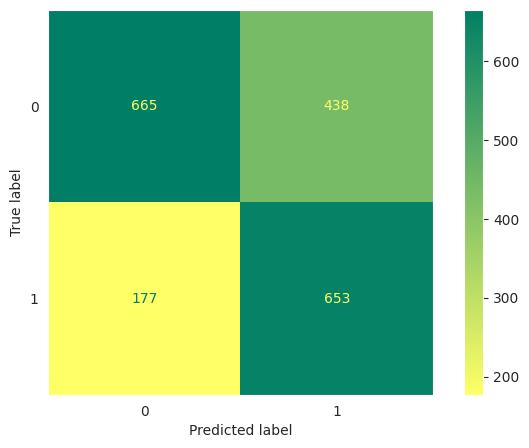

In [25]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [26]:
relatorios[modelo_numero]

{'acurácia': 0.6818416968442835,
 'precisão': 0.7076652728288632,
 'revocação': 0.6818416968442835,
 'pontuação-f1': 0.6821083937915633}

### Camadas iniciais padronizadas

In [27]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 67.2 ms, sys: 3.44 ms, total: 70.6 ms
Wall time: 154 ms


### Modelo 1: MLP

In [28]:
%%time

modelo_numero = 1

modelos_nome[modelo_numero] = 'MLP'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES_MLP,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/20
121/121 [==============================] - 34s 233ms/step - loss: 0.6661 - accuracy: 0.6687 - val_loss: 0.6379 - val_accuracy: 0.8117
Epoch 2/20
121/121 [==============================] - 30s 245ms/step - loss: 0.5970 - accuracy: 0.8679 - val_loss: 0.5597 - val_accuracy: 0.8681
Epoch 3/20
121/121 [==============================] - 27s 224ms/step - loss: 0.5031 - accuracy: 0.8772 - val_loss: 0.4770 - val_accuracy: 0.8650
Epoch 4/20
121/121 [==============================] - 25s 206ms/step - loss: 0.4150 - accuracy: 0.8791 - val_loss: 0.4116 - val_accuracy: 0.8686
Epoch 5/20
121/121 [==============================] - 24s 195ms/step - loss: 0.3449 - accuracy: 0.8842 - val_loss: 0.3654 - val_accuracy: 0.8681
Epoch 6/20
121/121 [==============================] - 22s 181ms/step - loss: 0.2904 - accuracy: 0.8904 - val_loss: 0.3317 - val_accuracy: 0.8743
Epoch 7/20
121/121 [==============================] - 20s 169ms/step - loss: 0.2461 - accuracy: 0.9051 - val_loss: 0.3067 - val_ac

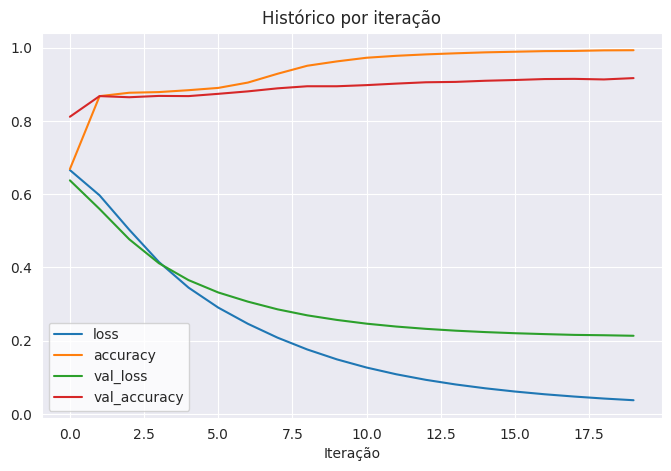

In [29]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1103
           1       0.94      0.86      0.90       830

    accuracy                           0.92      1933
   macro avg       0.92      0.91      0.91      1933
weighted avg       0.92      0.92      0.92      1933



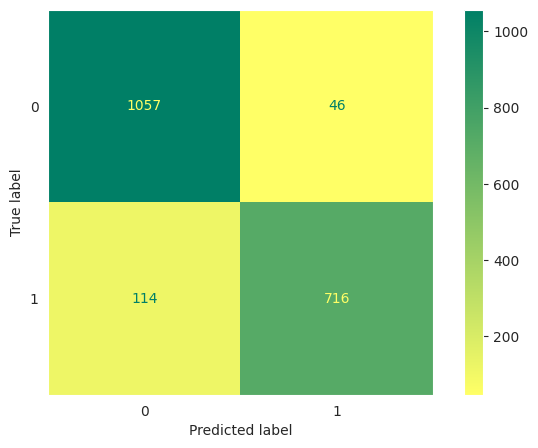

In [30]:
dados_modelo(modelo_numero)

In [31]:
relatorios[modelo_numero]

{'acurácia': 0.91722710812209,
 'precisão': 0.9185281924697053,
 'revocação': 0.91722710812209,
 'pontuação-f1': 0.9166969347682757}

### Modelo 2: CNN

In [32]:
%%time

modelo_numero = 2

modelos_nome[modelo_numero] = 'RNC'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_CONV,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 31s 208ms/step - loss: 0.5167 - accuracy: 0.7801 - val_loss: 0.3963 - val_accuracy: 0.8629
Epoch 2/3
121/121 [==============================] - 23s 188ms/step - loss: 0.2311 - accuracy: 0.9280 - val_loss: 0.2962 - val_accuracy: 0.8846
Epoch 3/3
121/121 [==============================] - 23s 190ms/step - loss: 0.0969 - accuracy: 0.9756 - val_loss: 0.2879 - val_accuracy: 0.8810
CPU times: user 1min 1s, sys: 1.54 s, total: 1min 2s
Wall time: 1min 17s


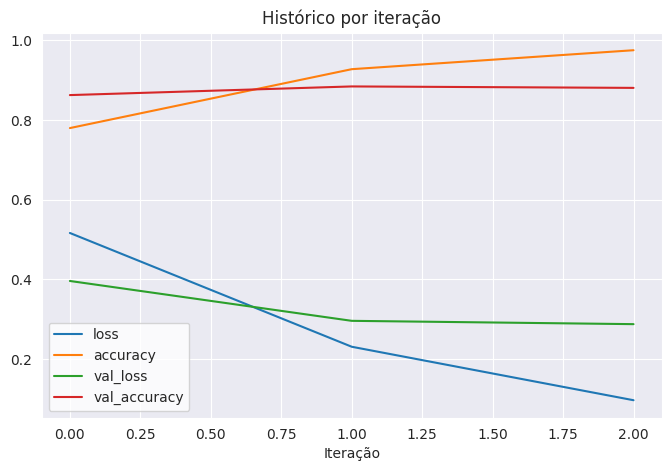

In [33]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1103
           1       0.85      0.88      0.86       830

    accuracy                           0.88      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.88      0.88      0.88      1933



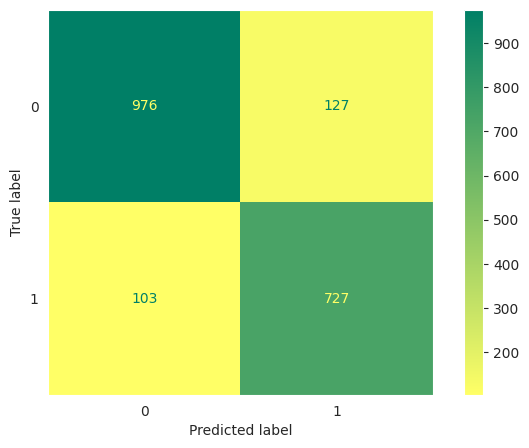

In [34]:
dados_modelo(modelo_numero)

In [35]:
relatorios[modelo_numero]

{'acurácia': 0.8810139679255043,
 'precisão': 0.8816751559526276,
 'revocação': 0.8810139679255043,
 'pontuação-f1': 0.881207480743529}

### Modelo 3: DCNN

In [36]:
%%time

modelo_numero = 3

modelos_nome[modelo_numero] = 'CFN-AI'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 30s 222ms/step - loss: 0.1656 - accuracy: 0.9379 - val_loss: 0.3659 - val_accuracy: 0.8743
Epoch 2/3
121/121 [==============================] - 26s 215ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.4309 - val_accuracy: 0.8769
Epoch 3/3
121/121 [==============================] - 30s 245ms/step - loss: 0.0077 - accuracy: 0.9968 - val_loss: 0.4928 - val_accuracy: 0.8712
CPU times: user 1min 6s, sys: 1.42 s, total: 1min 8s
Wall time: 2min 23s


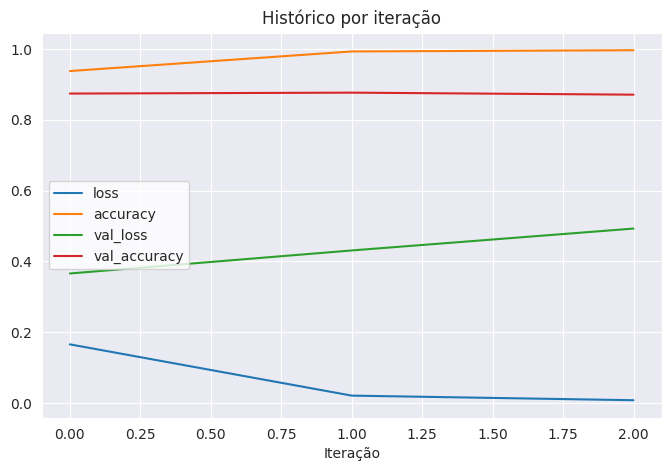

In [37]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1103
           1       0.82      0.90      0.86       830

    accuracy                           0.87      1933
   macro avg       0.87      0.87      0.87      1933
weighted avg       0.88      0.87      0.87      1933



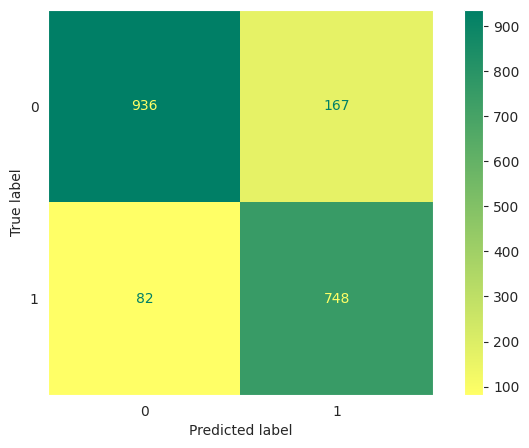

In [38]:
dados_modelo(modelo_numero)

In [39]:
relatorios[modelo_numero]

{'acurácia': 0.8711846870150026,
 'precisão': 0.875668340844532,
 'revocação': 0.8711846870150026,
 'pontuação-f1': 0.871740857794991}

### Modelo 4: RNN (LSTM Bidirecional)

In [40]:
%%time

modelo_numero = 4

modelos_nome[modelo_numero] = 'RNR'

camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 41s 299ms/step - loss: 0.4138 - accuracy: 0.8119 - val_loss: 0.2945 - val_accuracy: 0.8820
Epoch 2/3
121/121 [==============================] - 34s 283ms/step - loss: 0.1265 - accuracy: 0.9580 - val_loss: 0.3239 - val_accuracy: 0.8800
Epoch 3/3
121/121 [==============================] - 33s 271ms/step - loss: 0.0505 - accuracy: 0.9860 - val_loss: 0.3481 - val_accuracy: 0.9022
CPU times: user 1min 37s, sys: 3.52 s, total: 1min 40s
Wall time: 1min 49s


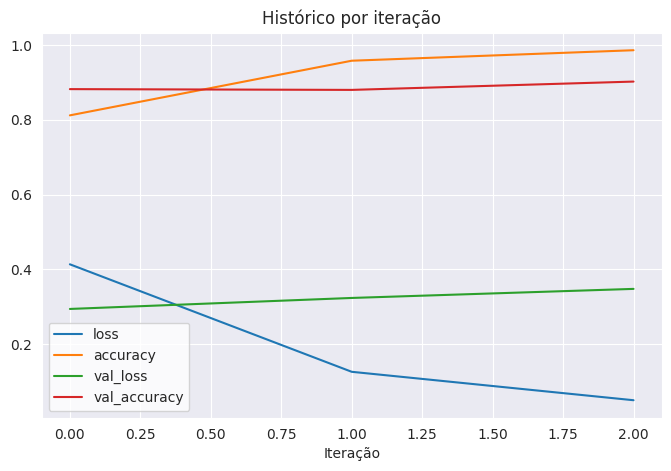

In [41]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1103
           1       0.87      0.91      0.89       830

    accuracy                           0.90      1933
   macro avg       0.90      0.90      0.90      1933
weighted avg       0.90      0.90      0.90      1933



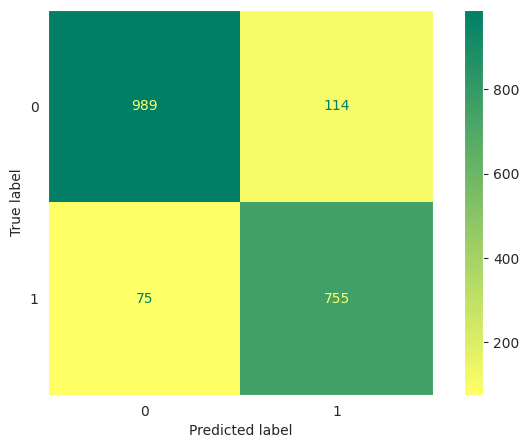

In [42]:
dados_modelo(modelo_numero)

In [43]:
relatorios[modelo_numero]

{'acurácia': 0.9022245214692188,
 'precisão': 0.9034491285029639,
 'revocação': 0.9022245214692188,
 'pontuação-f1': 0.9024668798958272}

### Modelo 5: Transformer

In [44]:
%%time

modelo_numero = 5

modelos_nome[modelo_numero] = 'Transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelos_nome[modelo_numero])

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_SAIDA,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 85s 579ms/step - loss: 0.6152 - accuracy: 0.6592 - val_loss: 0.4827 - val_accuracy: 0.7615
Epoch 2/3
121/121 [==============================] - 60s 494ms/step - loss: 0.4198 - accuracy: 0.8064 - val_loss: 0.4382 - val_accuracy: 0.7832
Epoch 3/3
121/121 [==============================] - 57s 471ms/step - loss: 0.3081 - accuracy: 0.8643 - val_loss: 0.4055 - val_accuracy: 0.8086
CPU times: user 3min 36s, sys: 22.9 s, total: 3min 59s
Wall time: 3min 40s


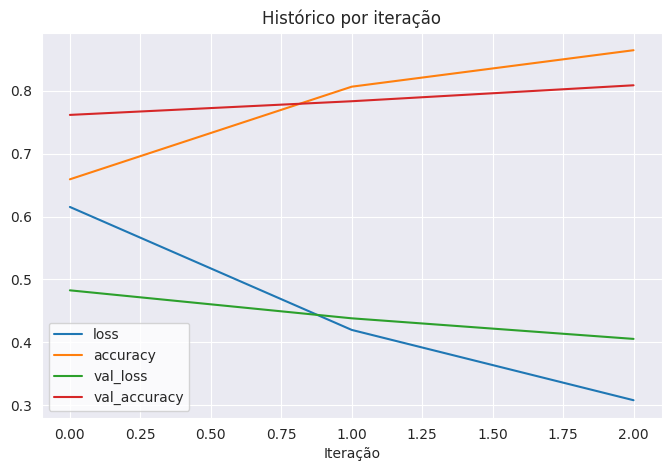

In [45]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 8s 122ms/step
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1103
           1       0.78      0.77      0.78       830

    accuracy                           0.81      1933
   macro avg       0.80      0.80      0.80      1933
weighted avg       0.81      0.81      0.81      1933



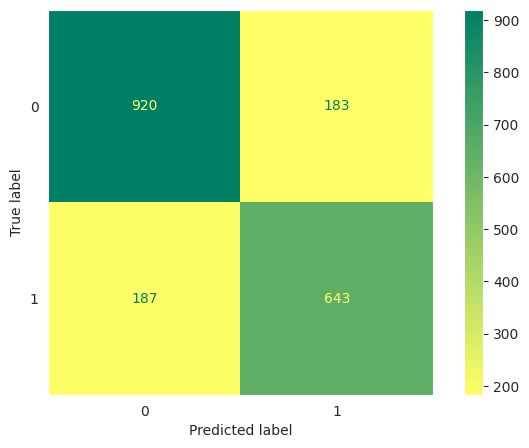

In [46]:
dados_modelo(modelo_numero)

In [47]:
relatorios[modelo_numero]

{'acurácia': 0.8085876875323331,
 'precisão': 0.8084787902447589,
 'revocação': 0.8085876875323331,
 'pontuação-f1': 0.8085297370541012}

### Modelo 6: fakeDETECTOR

In [48]:
%%time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

modelo_numero = 6
modelos_nome[modelo_numero] = 'fakeD'

train_texts = X_train.astype(str)
val_texts = X_val.astype(str)
test_texts = X_test.astype(str)

max_sequence_length = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

val_sequences = tokenizer.texts_to_sequences(val_texts)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200

modelos[modelo_numero] = Sequential()
modelos[modelo_numero].add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
modelos[modelo_numero].add(Conv1D(256, 5, activation='relu'))
modelos[modelo_numero].add(GlobalMaxPooling1D())
modelos[modelo_numero].add(Dense(256, activation='relu'))
modelos[modelo_numero].add(Dense(1, activation='sigmoid'))

modelos[modelo_numero].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historicos[modelo_numero] = modelos[modelo_numero].fit(train_sequences, y_train, epochs=4, batch_size=32, validation_data=(val_sequences, y_val))

Epoch 1/4
242/242 [==============================] - 60s 241ms/step - loss: 0.3749 - accuracy: 0.8298 - val_loss: 0.2910 - val_accuracy: 0.8738
Epoch 2/4
242/242 [==============================] - 52s 216ms/step - loss: 0.0921 - accuracy: 0.9686 - val_loss: 0.2250 - val_accuracy: 0.9126
Epoch 3/4
242/242 [==============================] - 46s 190ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.2643 - val_accuracy: 0.9115
Epoch 4/4
242/242 [==============================] - 39s 160ms/step - loss: 0.0069 - accuracy: 0.9968 - val_loss: 0.2437 - val_accuracy: 0.9177
CPU times: user 2min 21s, sys: 2.85 s, total: 2min 24s
Wall time: 3min 19s


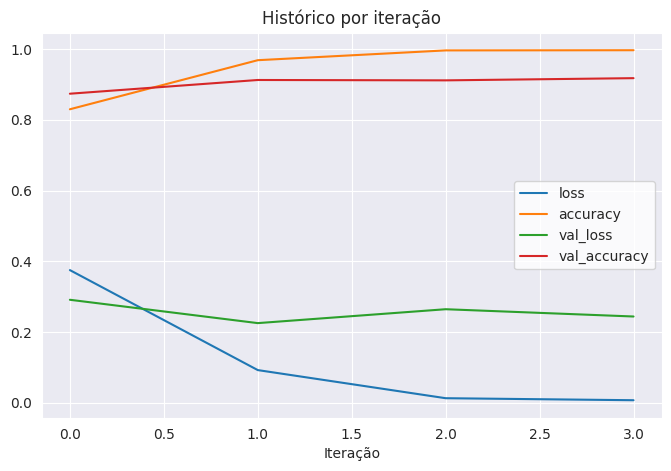

In [80]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1103
           1       0.91      0.90      0.90       830

    accuracy                           0.92      1933
   macro avg       0.92      0.92      0.92      1933
weighted avg       0.92      0.92      0.92      1933



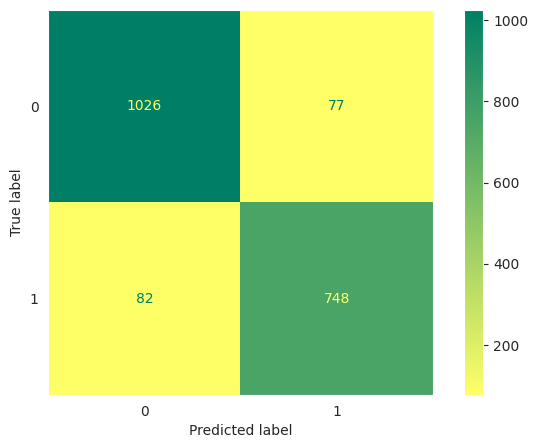

In [81]:
dados_modelo(modelo_numero)


In [82]:
relatorios[modelo_numero]

{'acurácia': 0.9177444386963269,
 'precisão': 0.9176944487503447,
 'revocação': 0.9177444386963269,
 'pontuação-f1': 0.9177131927753652}

### Modelo 7: fakeDETECTOR HDF5

In [72]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# train_texts = X_train.astype(str)
# val_texts = X_val.astype(str)
# test_texts = X_test.astype(str)

# max_sequence_length = 1000

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(train_texts)

# val_sequences = tokenizer.texts_to_sequences(val_texts)
# val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

# test_sequences = tokenizer.texts_to_sequences(test_texts)
# test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [ ]:
# %%time

# modelo_numero = 7

# modelos_nome[modelo_numero] = 'fakeD-H5'

# modelos[modelo_numero] = tf.keras.models.load_model('fakeDETECTOR_HDF5.h5')

In [ ]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [ ]:
# dados_modelo(modelo_numero, val_sequences)

In [ ]:
# relatorios[modelo_numero]

## Comparar modelos

In [83]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

## Teste modelos

In [ ]:
for modelo_numero, modelo in enumerate(modelos):
    teste_modelo(modelo_numero)
    print(modelos_nome[modelo_numero] + ": ")
    print(relatorios[modelo_numero])

In [77]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

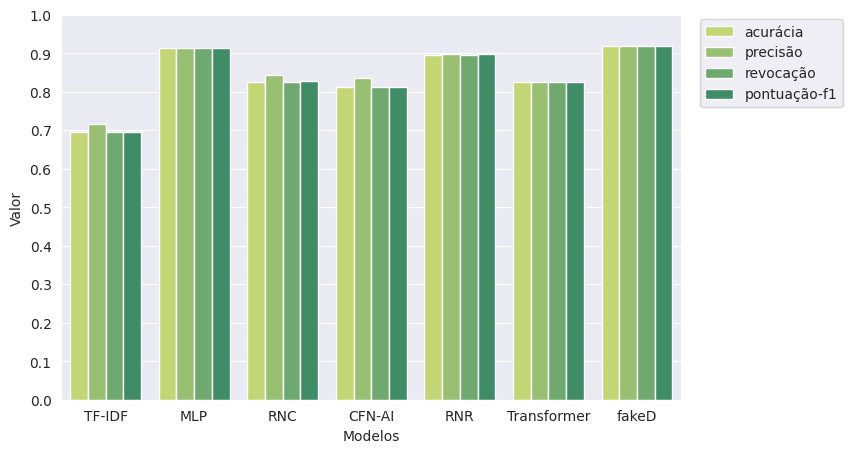

In [85]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.0, 1.0)

# plt.title('Medidas de avaliação dos modelos - Dados de teste')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.xticks(ticks=np.arange(len(modelos_nome)), labels=modelos_nome)
plt.yticks(ticks=np.arange(0.0, 1.01, 0.1))

plt.legend(loc=(1.03, 0.76));